In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch import nn
import torchvision
from torchvision import transforms


from pathlib import Path
FIG_FOLDER = Path("../res/ML_Exercises/GB500/exercise_list_3/report/figures/")

# Problem Statement

Consider a database and a classification problem. Apply leave-one-out multi-fold cross-validation ex-
plained in section 8.5 of [2], with K = 5, for a CNN model. Use the facilities available in libraries for
neural network implementation, like Keras, Tensor flow, etc. [3].


- (a) Show the graphical representation of the evolution of training and validation stages (see Figure
8.8 of the course monograph).

- (b) Perform a statistical analysis of the performance (section 8.6) of the five models applied over the
Dte .

# Loading Data

Let's use the MNIST database from torch datasets, downloading it automatically. Let's also use the DataLoader abstraction to make it simpler to do batches.

In [2]:
from functools import partial

test_data = torchvision.datasets.MNIST(
    "~/Documents/Data/MNIST", 
    download=True, train=False, 
    transform=transforms.ToTensor(),
    target_transform=torchvision.transforms.Compose([torch.tensor, partial(F.one_hot, num_classes=10), lambda x: x.to(torch.float32)])
)


train_data = torchvision.datasets.MNIST(
    "~/Documents/Data/MNIST",
    download=True, train=True, 
    transform=torchvision.transforms.ToTensor() ,
    target_transform=torchvision.transforms.Compose([torch.tensor, partial(F.one_hot, num_classes=10), lambda x: x.to(torch.float32)])
)

In [3]:
from torch.utils.data import RandomSampler

BATCH_SIZE = 50

dataset_train = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

dataset_test = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True,)# sampler=RandomSampler(test_data))

In [505]:
x_val, y_val = next(iter(dataset_test))

x_val.shape, y_val.shape

(torch.Size([200, 1, 28, 28]), torch.Size([200, 10]))

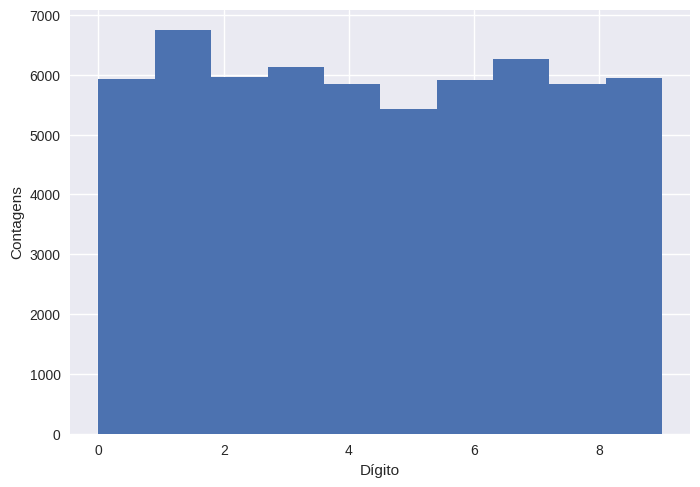

In [367]:
plt.hist(dataset_train.sampler.data_source.targets.detach())

plt.xlabel("Dígito")
plt.ylabel("Contagens")

plt.savefig(FIG_FOLDER / "class_balance.png", dpi=100)

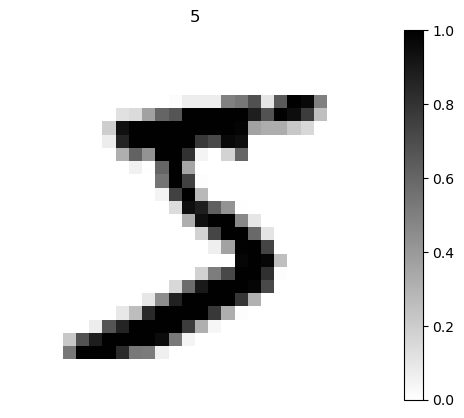

In [382]:
plt.style.use("default")

x, y = train_data[0]

plt.imshow(x.detach().reshape(28, 28), cmap="gray_r")
plt.title(torch.argmax(y).item())

plt.colorbar()
plt.axis("off")

plt.savefig(FIG_FOLDER / "mnist_example.png", dpi=100)

# Basic CNN

Let's start by defining a simple CNN to test the waters before going to cross validation.

In [4]:
# Defining the network

class SimpleCNN(nn.Module):

    def __init__(self):
        
        super().__init__()

        self.net = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=7),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(in_features=16*11*11, out_features=200),
            # nn.ReLU(),
            # nn.Linear(in_features=200, out_features=100),
            nn.ReLU(),
            nn.Linear(in_features=200, out_features=10),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        return self.net(x)

def accuracy(out, y):
    return torch.mean((torch.argmax(out, axis=1) == torch.argmax(y, axis=1)).to(torch.float16)).item()

In [516]:


model = torch.compile(SimpleCNN())
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.SGD(model.parameters(), lr=0.5)

E = 3

test_batches = iter(dataset_test)

losses_train = []
losses_val = []
acc_train = []
acc_val = []

for i in range(E):

    losses_train.append([])
    losses_val.append([])
    acc_train.append([])
    acc_val.append([])
    
    for j, (x_train, y_train) in enumerate(dataset_train, 1):
    
        opt.zero_grad()
        out = model(x_train)
        loss = loss_fn(out, y_train)
        
        losses_train[i].append(loss.item())

        with torch.no_grad():

            # Hack to allow for validation batches to cycle 
            # the same amount of times of the training set
            
            try:
                x_val, y_val = next(test_batches)
            except StopIteration:
                test_batches = iter(dataset_test)
                x_val, y_val = next(test_batches)

            
            out_val = model(x_val)

            losses_val[i].append(loss_fn(out_val, y_val).item())
            
            acc_train[i].append(accuracy(out, y_train))
            acc_val[i].append(accuracy(out_val, y_val)) 
            

            if j % 100 == 0:
                print(i, f"{losses_train[i][-1]:.2f}")
                print(i, f"{acc_train[i][-1]:.2f}") 
        
        loss.backward()
        opt.step()

    print()
    print(i, f"LOSS_t = {np.mean(losses_train[i]):.2f}")
    print(i, f"ACCURACY_t = {np.mean(acc_train[i]):.2f}\n")   

    print(i, f"LOSS_v = {np.mean(losses_val[i]):.2f}")
    print(i, f"ACCURACY_v = {np.mean(acc_val[i]):.2f}\n")   

0 1.83
0 0.66
0 1.60
0 0.86
0 1.52
0 0.94
0 1.51
0 0.96
0 1.52
0 0.94
0 1.52
0 0.94
0 1.50
0 0.96
0 1.51
0 0.96
0 1.50
0 0.94
0 1.49
0 0.98
0 1.52
0 0.96
0 1.50
0 0.96

0 LOSS_t = 1.56
0 ACCURACY_t = 0.90

0 LOSS_v = 1.56
0 ACCURACY_v = 0.94

1 1.48
1 0.98
1 1.48
1 0.98
1 1.48
1 0.98
1 1.49
1 0.98
1 1.49
1 0.98
1 1.50
1 0.96
1 1.53
1 0.94
1 1.48
1 0.98
1 1.48
1 0.98
1 1.47
1 1.00
1 1.48
1 0.98
1 1.46
1 1.00

1 LOSS_t = 1.49
1 ACCURACY_t = 0.97

1 LOSS_v = 1.49
1 ACCURACY_v = 0.96

2 1.46
2 1.00
2 1.48
2 0.98
2 1.46
2 1.00
2 1.48
2 0.98
2 1.49
2 0.98
2 1.47
2 1.00
2 1.46
2 1.00
2 1.50
2 0.96
2 1.46
2 1.00
2 1.49
2 0.96
2 1.48
2 0.98
2 1.47
2 1.00

2 LOSS_t = 1.48
2 ACCURACY_t = 0.98

2 LOSS_v = 1.48
2 ACCURACY_v = 0.98



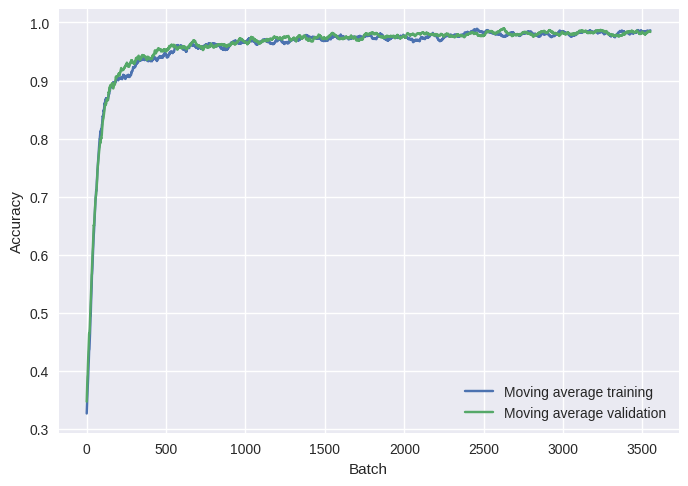

In [517]:
plt.style.use("seaborn-v0_8")
W = 50

accuracies_train = np.array(acc_train)
accuracies_val = np.array(acc_val)

losses_val = np.array(losses_val)
losses_train = np.array(losses_train)

# plt.plot(accuracies_train.ravel())

plt.plot(np.convolve(accuracies_train.ravel(), np.ones(W)/W, mode="valid"),label="Moving average training")


# plt.plot(accuracies_val.ravel())
plt.plot(np.convolve(accuracies_val.ravel(), np.ones(W)/W, mode="valid"), label="Moving average validation")

plt.ylabel("Accuracy")
plt.xlabel("Batch")

plt.legend()

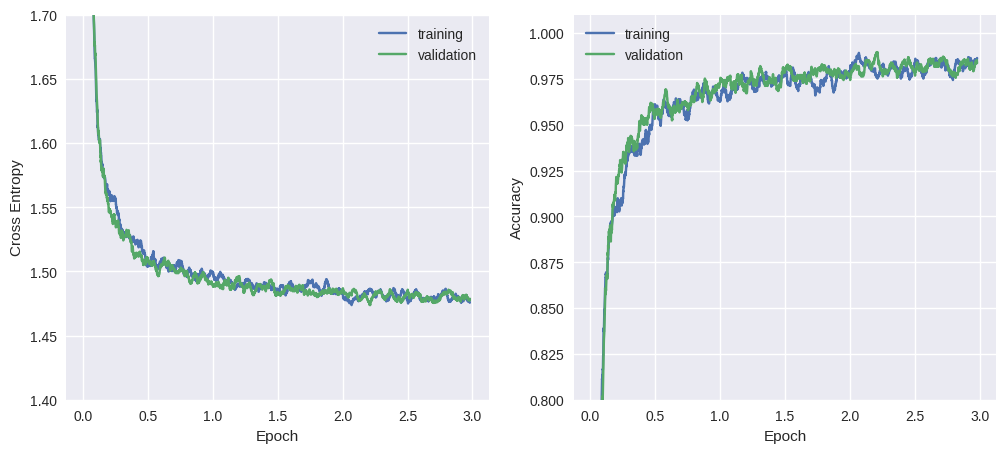

In [521]:
fig, [ax1, ax2] = plt.subplots(ncols=2, figsize=(12, 5))


xs = np.arange(0 + W/2, E*1_200 - W/2 + 1)/1200

ax1.plot(xs, np.convolve(losses_train.ravel(), np.ones(W)/W, mode="valid"),label="training")
ax1.plot(xs, np.convolve(losses_val.ravel(), np.ones(W)/W, mode="valid"), label="validation")

ax1.set_ylabel("Cross Entropy")
ax1.set_xlabel("Epoch")
ax1.set(ylim=(1.4, 1.7))


ax2.plot(xs, np.convolve(accuracies_train.ravel(), np.ones(W)/W, mode="valid"),label="training")
ax2.plot(xs, np.convolve(accuracies_val.ravel(), np.ones(W)/W, mode="valid"), label="validation")

ax2.set_ylabel("Accuracy")
ax2.set_xlabel("Epoch")

ax2.set(ylim=(0.8, 1.01))


ax1.legend()
ax2.legend()

plt.savefig(FIG_FOLDER / "example_evolution.png", dpi=100)

/tmp/ipykernel_827816/2255678376.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


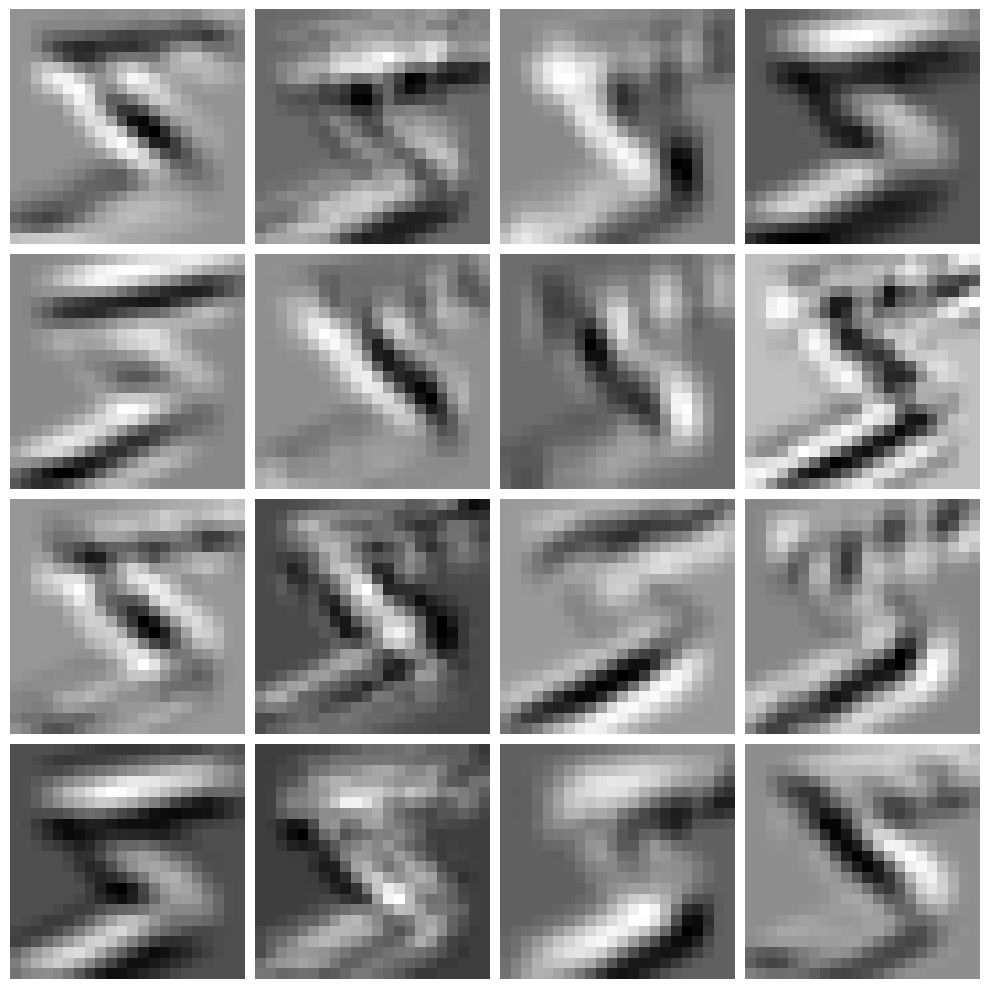

In [428]:
plt.style.use("default")

with torch.no_grad():
    conv = model.net[0](x)

from mpl_toolkits.axes_grid1 import ImageGrid


# fig, axes = plt.subplots(ncols=4, nrows=8, sharex=True, sharey=True)

fig = plt.figure(figsize=(10., 10.))

grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(4, 4),  # creates 2x2 grid of Axes
                 axes_pad=0.1,  # pad between Axes in inch.
                 )

for c, ax in zip(conv, grid):
    ax.imshow(c, cmap="gray_r")
    ax.axis("off")

plt.tight_layout()

plt.savefig(FIG_FOLDER / "convolution.png", dpi=100)

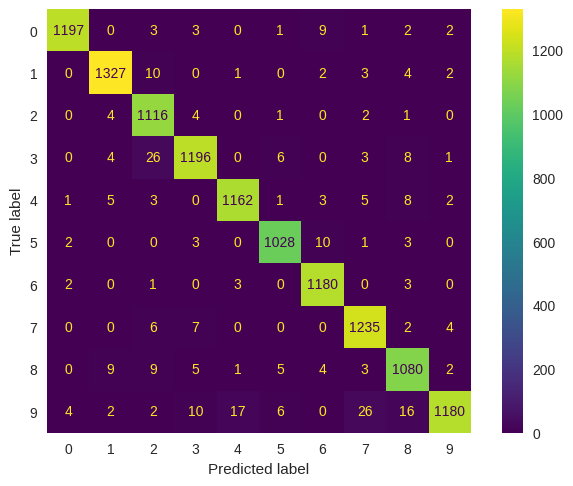

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
plt.style.use("seaborn-v0_8")


conf = confusion_matrix(torch.argmax(model(x_val), axis=1), torch.argmax(y_val, axis=1))

c =ConfusionMatrixDisplay(conf).plot()
c.ax_.grid(False)

plt.savefig("../report/figures/cnn_confusion_k=1.png", dpi=100)

In [18]:
d = np.diag(conf).copy()

np.fill_diagonal(conf, 0)


array([[1197,    0,    3,    3,    0,    1,    9,    1,    2,    2],
       [   0, 1327,   10,    0,    1,    0,    2,    3,    4,    2],
       [   0,    4, 1116,    4,    0,    1,    0,    2,    1,    0],
       [   0,    4,   26, 1196,    0,    6,    0,    3,    8,    1],
       [   1,    5,    3,    0, 1162,    1,    3,    5,    8,    2],
       [   2,    0,    0,    3,    0, 1028,   10,    1,    3,    0],
       [   2,    0,    1,    0,    3,    0, 1180,    0,    3,    0],
       [   0,    0,    6,    7,    0,    0,    0, 1235,    2,    4],
       [   0,    9,    9,    5,    1,    5,    4,    3, 1080,    2],
       [   4,    2,    2,   10,   17,    6,    0,   26,   16, 1180]])

# K-Fold cross validation

Let's adapt the training loop above to do Cross Validation with K=5.

In [6]:
from torch.utils.data import DataLoader, Subset
mnist = torchvision.datasets.MNIST(
    "~/Documents/Data/MNIST", 
    download=True, 
    transform=transforms.ToTensor(),
    target_transform=torchvision.transforms.Compose([torch.tensor, partial(F.one_hot, num_classes=10), lambda x: x.to(torch.float32)])
)

Subset(mnist, range(0, 100))

In [20]:
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

kf = KFold(5)

final_val_accuracies = []
final_val_losses = []

confusions = []

E=3


for k, (train_idx, val_idx) in enumerate(kf.split(mnist), 1):


    print(f"Starting K={k}")
    
    dataloader_train = DataLoader(dataset=Subset(mnist, train_idx), batch_size=50, shuffle=True)
    dataloader_val = DataLoader(dataset=Subset(mnist, val_idx), batch_size=len(val_idx), shuffle=True)


    model = torch.compile(SimpleCNN())
    loss_fn = nn.CrossEntropyLoss()
    opt = torch.optim.SGD(model.parameters(), lr=0.5)

    for i in range(1, E+1):

        print(f"Epoch = {i}")

    
        for j, (x_train, y_train) in enumerate(dataloader_train, 1):
    
            opt.zero_grad()
            out = model(x_train)
            loss = loss_fn(out, y_train)
        
            loss.backward()
            opt.step()

    
    x_val, y_val = next(iter(dataloader_val))


    with torch.no_grad():
        out = model(x_val)
        final_val_accuracies.append(accuracy(out, y_val))
        final_val_losses.append(loss_fn(out, y_val).item())

        confusions.append(confusion_matrix(torch.argmax(out, axis=1), torch.argmax(y_val, axis=1)))
        

    print("Final Acc: ", final_val_accuracies[-1])
    


Starting K=1
Epoch = 1
Epoch = 2
Epoch = 3
Final Acc:  0.97705078125
Starting K=2
Epoch = 1
Epoch = 2
Epoch = 3
Final Acc:  0.9814453125
Starting K=3
Epoch = 1
Epoch = 2
Epoch = 3
Final Acc:  0.98046875
Starting K=4
Epoch = 1
Epoch = 2
Epoch = 3
Final Acc:  0.974609375
Starting K=5
Epoch = 1
Epoch = 2
Epoch = 3
Final Acc:  0.98095703125


In [21]:
np.mean(final_val_accuracies), np.std(final_val_accuracies)

(np.float64(0.97890625), np.float64(0.002645745543778138))

In [39]:
conf_cube = np.stack(confusions, axis=0)

conf_mean = conf_cube.mean(axis=0)
conf_std = conf_cube.std(axis=0)

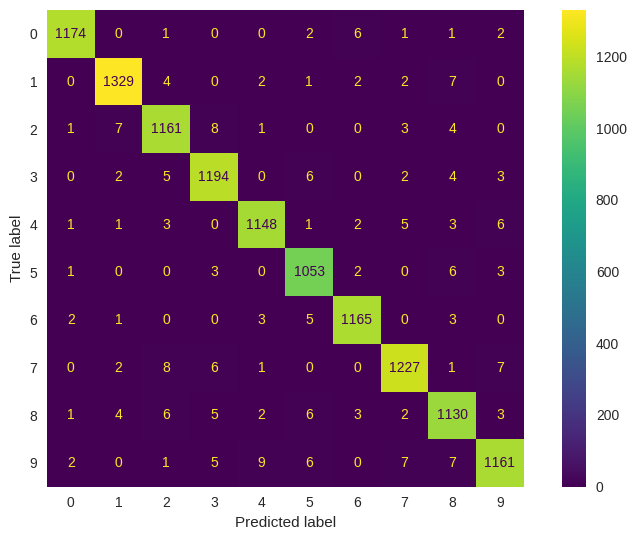

In [47]:
c = ConfusionMatrixDisplay(conf_mean.astype(int)).plot()
c.ax_.grid(False)
plt.tight_layout()

plt.savefig("../report/figures/q2_mean_conf.png", dpi=100)

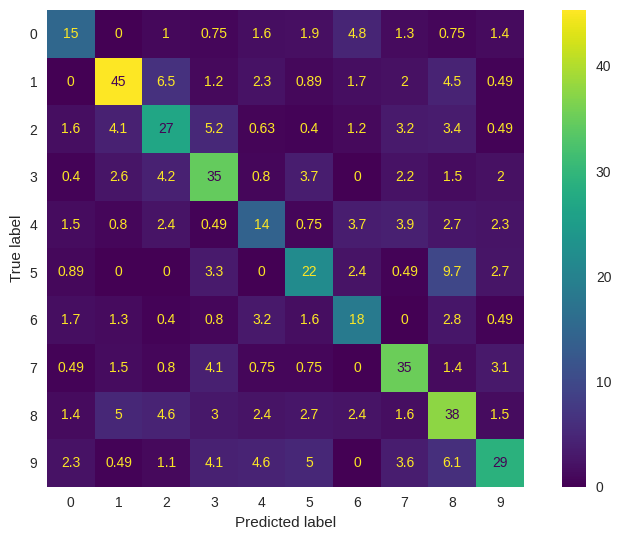

In [46]:
c = ConfusionMatrixDisplay(conf_std).plot()
c.ax_.grid(False)
plt.tight_layout()

plt.savefig("../report/figures/q2_std_conf.png", dpi=100)

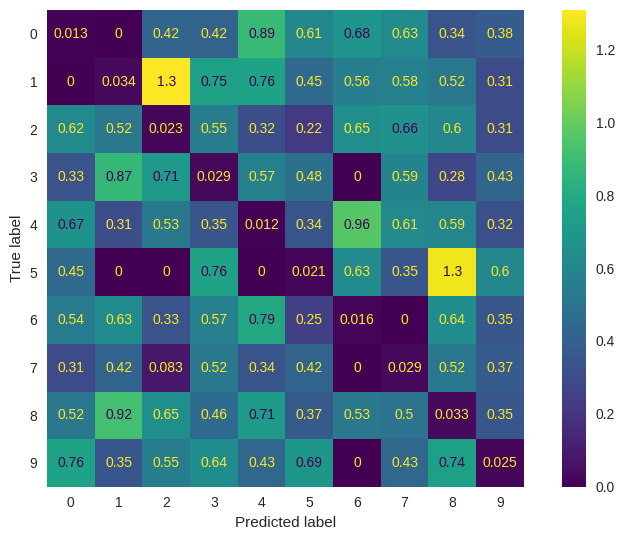

In [48]:
c = ConfusionMatrixDisplay(conf_std/(conf_mean +1)).plot()
c.ax_.grid(False)
plt.tight_layout()

plt.savefig("../report/figures/q2_std_norm_conf.png", dpi=100)